# Image Processing and Shape Detection Concepts (Day 3, First Session)

In this session, we will build on what we learned in Day 2 about using masks and contours for object detection. Our focus today is on shape detection – we’ll learn how to simplify object contours and classify basic shapes like triangles, rectangles, and circles. By the end of this notebook, you’ll understand how to use OpenCV’s cv2.approxPolyDP function to approximate contours and identify the shape based on the number of vertices. This is a key skill for our final AI-powered sorting robot project!

## Learning Goals
- Review Day 2 concepts: contours, masks, and basic object detection.
- Contour Approximation: Understand how cv2.approxPolyDP simplifies a contour by reducing its vertices.
- Shape Classification: Determine if a contour is a triangle, quadrilateral (rectangle), circle, etc., by counting its vertices after approximation.
- Coding Practice: Use OpenCV to find contours, approximate them, and label images with detected shape names.
- Connection to Robotics: Discuss how robots can use color and shape information to identify and sort objects in the real world.

(Throughout this notebook, we include reflection questions and mentor discussion cues to think deeper about the concepts. Feel free to pause and discuss these with your peers or instructors.)


### Review: Contours, Masks, and Object Detection (from Day 2)

In Day 2, we learned how to isolate objects in an image using color masks and find their contours. Recall that a mask is a binary image (black and white) where white pixels represent the region of interest (for example, all pixels of a certain color) and black pixels represent the background. Using a mask, we applied cv2.findContours to get the outlines of objects of interest.

Let’s quickly recap this with a simple example:
- Step 1: Load an image and convert it to the HSV color space (which is often easier for color segmentation).
- Step 2: Define a color range to create a mask for that color.
- Step 3: Use cv2.findContours on the mask to find object boundaries.
- Step 4: Draw the contours or highlight the detected object.

We won’t spend too long on this, but it’s important to remember because we will combine color masks with shape detection in our projects.

📌 If you need a refresher, look back at your Day 2 notebook to see how we created masks for different colors and detected objects.

Example Recap: Suppose we want to detect a blue object in an image (like a blue piece of paper). We would do something like:

--2025-06-02 17:37:18--  https://upload.wikimedia.org/wikipedia/commons/1/1c/6sided_dice_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341584 (334K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 333.58K  --.-KB/s    in 0.05s   

2025-06-02 17:37:18 (5.94 MB/s) - ‘image.jpg’ saved [341584/341584]



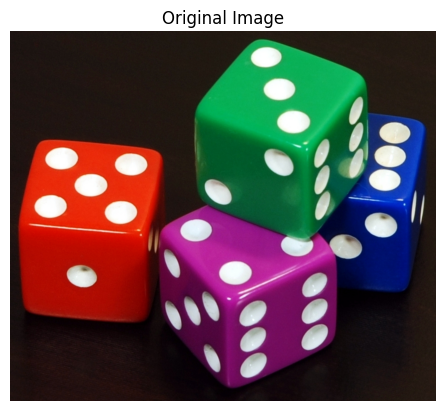

Found 19 contours for blue objects.


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/1/1c/6sided_dice_%28cropped%29.jpg -O image.jpg

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (suppose 'image.jpg' has a blue object on a white background)
img = cv2.imread('image.jpg')

# Show original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')  # hide axis ticks
plt.show()

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define HSV range for blue (these values might need tuning for different images)
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([130, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Find contours on the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} contours for blue objects.")


If the blue object is detected correctly, we should get at least one contour. We could then draw it on the original image or compute properties like the area or center of the contour. For example:


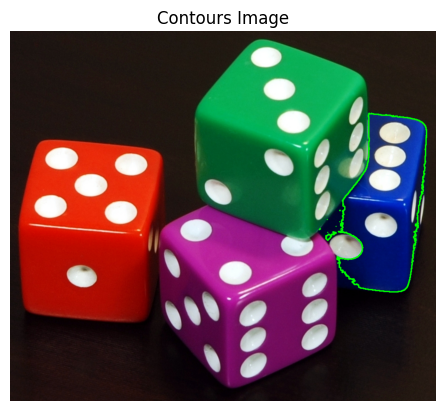

In [ ]:
# Draw the found contour onto the original image
for cnt in contours:
    cv2.drawContours(img, [cnt], -1, (0,255,0), 2)  # draw contour in green for visualization

# Display or save the result (in a Jupyter/Colab environment use cv2_imshow or plt.imshow)
cv2.imwrite('blue_detected.png', img)

# Show contours image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Contours Image")
plt.axis('off')  # hide axis ticks
plt.show()

In the above snippet, we used cv2.inRange to create a mask for a blue color range and then found contours. cv2.RETR_EXTERNAL retrieves only the outer contours (useful when objects are not nested), and cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments, leaving only their end points (this saves memory). We’ll talk more about contour approximation in a moment.

Reflection: Why do we use color masks before finding contours? Think about how using a mask helps isolate the object of interest (by color) so that findContours doesn’t give us a lot of irrelevant outlines. If we didn’t use a mask, every little variation or feature in the image could become a contour!

### Contour Approximation with cv2.approxPolyDP

Now, onto the new concept: contour approximation. When we detect a contour, it might consist of a lot of points – especially if the object has a curved shape or irregular edges. For example, a circle might have dozens of contour points, and a slightly noisy square could have many points along each side. In robotics and computer vision, we often want to simplify these contours to just the key points that define the shape (e.g., the corners of a polygon). This simplification makes it easier to recognize the shape and is more computationally efficient.

Key idea: The OpenCV function cv2.approxPolyDP(curve, epsilon, closed) implements the Ramer–Douglas–Peucker (RDP) algorithm to approximate a curve or polygon with fewer points. Essentially, we give it a contour and a tolerance value (epsilon), and it returns a new, simplified contour.

- curve is the original contour (a list of points).
- epsilon is the maximum distance allowed between the original contour and the approximated contour. This is usually chosen as some fraction of the contour’s perimeter (arc length). A smaller epsilon means the approximation is closer to the original contour (more points kept); a larger epsilon means more simplification (fewer points).
- closed is a boolean indicating if the contour is closed (True for shapes).

For example, if we have a contour for a shape, we can do:

In [ ]:
perimeter = cv2.arcLength(cnt, True)  # calculate contour perimeter (True indicates closed contour)
epsilon = 0.02 * perimeter           # 2% of the perimeter as tolerance (this factor can be adjusted)
approx = cv2.approxPolyDP(cnt, epsilon, True)


The result approx is a new contour with (hopefully) fewer points that still roughly outlines the original shape. How does this work? The RDP algorithm works by recursively removing points that lie “almost” in a straight line and only keeping the points that create significant changes in direction. If you imagine tracing around a shape, approxPolyDP basically says “hey, these intermediate points aren’t that important, I can connect the shape with a straight line from point A to point C and skip point B if B doesn’t deviate much from the line.” The parameter epsilon controls how much deviation we allow.

Let’s visualize the effect of contour approximation on a shape. We will use a simple example image containing a few basic shapes. We’ll find their contours and then approximate those contours with cv2.approxPolyDP. Finally, we’ll draw the approximated contours on the image to see the difference.

First, create or load a sample image with simple shapes (for reproducibility, we’ll generate one using OpenCV drawing functions):

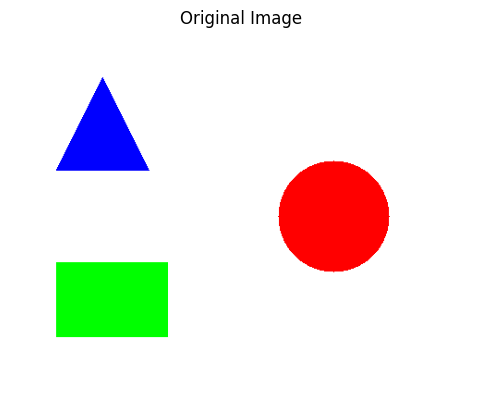

In [ ]:
import cv2
import numpy as np

# Create a blank white image
image = np.ones((400, 500, 3), dtype=np.uint8) * 255  # height=400, width=500

# Draw a blue triangle
triangle_cnt = np.array([[50, 150], [150, 150], [100, 50]])  # coordinates of triangle vertices
cv2.drawContours(image, [triangle_cnt], 0, (255, 0, 0), -1)  # filled blue triangle (BGR color)

# Draw a red circle
cv2.circle(image, (350, 200), 60, (0, 0, 255), -1)  # filled red circle

# Draw a green rectangle
cv2.rectangle(image, (50, 250), (170, 330), (0, 255, 0), -1)  # filled green rectangle

# Save or display the generated image
cv2.imwrite('shapes.png', image)

# Show original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

At this point, image contains three shapes: a blue triangle, a red circle, and a green rectangle, all on a white background. Let’s find all contours in this image and approximate them:


Detected 3 contours
Contour has 4 points, approximation has 4 points.
Contour has 164 points, approximation has 8 points.
Contour has 201 points, approximation has 3 points.


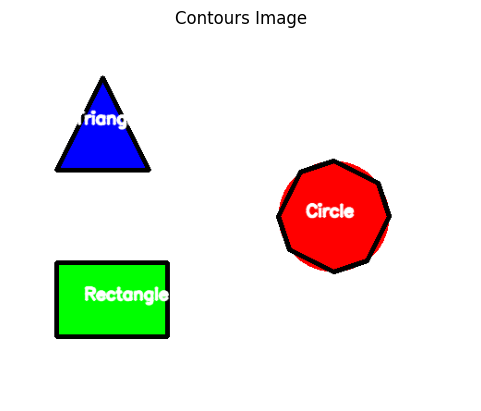

In [ ]:
# Convert to grayscale and threshold to get binary image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV with high threshold (254) will turn the shapes (non-white regions) white and background black.

# Find contours of the shapes
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Detected {len(contours)} contours")

# Make a copy of the image to draw results
output = image.copy()

for cnt in contours:
    # Compute contour perimeter
    peri = cv2.arcLength(cnt, True)
    # Approximate the contour
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    print(f"Contour has {len(cnt)} points, approximation has {len(approx)} points.")

    # Draw the original contour (for comparison, dotted line) and approximated contour (solid line)
    # (In practice, we'll just draw the approximated contour for clarity)
    cv2.drawContours(output, [approx], -1, (0, 0, 0), 3)  # draw approx contour in black

    # Identify shape based on number of vertices in approx
    vertices = len(approx)
    if vertices == 3:
        shape_name = "Triangle"
    elif vertices == 4:
        shape_name = "Rectangle"  # (or Square/Quadrilateral)
    elif vertices == 5:
        shape_name = "Pentagon"
    elif vertices == 6:
        shape_name = "Hexagon"
    else:
        shape_name = "Circle"    # assume any shape with >6 approx vertices is a circle

    # Find center of the contour to place text (using bounding box center for simplicity)
    x, y, w, h = cv2.boundingRect(approx)
    cx, cy = x + w//2, y + h//2
    # Put shape name text
    cv2.putText(output, shape_name, (cx - 30, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

cv2.imwrite('shapes_detected.png', output)

# Show Contours image
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Contours Image")
plt.axis('off')
plt.show()

In the loop above, we printed the number of original contour points vs approximated points for each shape, so you can see the reduction in complexity. We then drew the approximated contour in black and labeled the shape name. The result image output should have the shapes outlined and labeled.

Let’s examine the outcome:

Example output after contour approximation and shape labeling. In this image, our program detected a Triangle, a Rectangle, and a Circle. Notice how the red circle is outlined by an octagon-like shape – this is because our approximation simplified the circle’s many contour points down to about 8 vertices (an octagon). With a smaller epsilon (tighter tolerance), the approximated contour for the circle would have more points and look smoother, and with a larger epsilon, it might approximate the circle with even fewer points (maybe a hexagon or square!). The triangle and rectangle, having straight edges, were detected with the correct number of vertices (3 and 4 respectively).

### Shape Classification by Vertex Count
From the example above, we saw how we can classify shapes by counting the vertices of the approximated contour:

- 3 vertices → Triangle: If the approximation has 3 points, we assume the object is a triangle.
- 4 vertices → Rectangle/Quadrilateral: Four points usually indicate a quadrilateral. This could be a rectangle or square (or even a diamond shape if rotated). We’ll keep it simple and call it a “rectangle” in our context. If needed, one could differentiate a square vs rectangle by checking side lengths, but that’s extra detail we may not need now.
- 5 vertices → Pentagon (5-sided polygon).
- 6 vertices → Hexagon (6-sided polygon).
- >6 vertices → Circle: If we have a lot of vertices, the shape is likely meant to be round. (It could also be an irregular polygon, but for basic classification this works.) Essentially, beyond 6 sides, it’s hard to tell by vertices alone, so we lump those as “circle” for simplicity.

This rule-based classification works for distinct simple shapes and is a common approach in computer vision tutorials. It’s not foolproof for every scenario (for example, an oval might be approximated with 8 vertices but it’s not a circle in the geometric sense), but it’s a good heuristic for many practical cases.

Reflection: Can you think of shapes or scenarios where counting vertices might be misleading? Consider shapes that are nearly round versus ones that are perfectly polygonal, or shapes that have indentations (concave shapes). For instance, a star shape has 10 vertices but is not a circle – our simple scheme would mislabel it. That’s okay for now, because we’re focusing on basic distinct shapes on a clean background. In real robotics tasks, we might have to handle such cases with more advanced logic or machine learning.

### Relevance to Robotics and Our Project

Why are we learning shape detection? In many robotics applications, recognizing the shape of objects is crucial. For example, a sorting robot might need to separate items by shape (circles vs squares), or a robot might look for triangular markers or circular buttons in its environment. By combining shape information with color, a robot can make more precise identifications – for instance, “grab the blue triangle block and place it in the triangular hole” requires recognizing both the color and the shape.

In our AI4All project, we aim to build a simple vision system that can sort or identify objects by color and shape, similar to a toy sorting box that only accepts the right shape. Understanding contour approximation gives us a tool to translate the raw contour data into something meaningful (the name of a shape).

🗣 Discussion: Think about a self-driving car – how might shape detection be useful? (Hint: Road signs have distinct shapes – octagons for stop signs, rectangles for speed limit signs, etc. A vision system can approximate the contour of a sign and quickly determine its shape, which is one clue to what type of sign it is.) Similarly, industrial robots often use colored markers (circular stickers or triangular tags) to mark positions – detecting the shape of those markers can confirm the robot is looking at the right thing.

Before moving on, make sure you understand the code above and how the shape names were determined. Play with the epsilon value in cv2.approxPolyDP to see how it affects the output. For instance, try epsilon = 0.005 * peri (a tighter approximation) or epsilon = 0.05 * peri (a looser approximation) and observe the changes:


In [ ]:
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    for eps_factor in [0.005, 0.02, 0.05]:
        approx = cv2.approxPolyDP(cnt, eps_factor * peri, True)
        print(f"Epsilon {eps_factor}: {len(approx)} vertices")


Epsilon 0.005: 4 vertices
Epsilon 0.02: 4 vertices
Epsilon 0.05: 4 vertices
Epsilon 0.005: 16 vertices
Epsilon 0.02: 8 vertices
Epsilon 0.05: 4 vertices
Epsilon 0.005: 3 vertices
Epsilon 0.02: 3 vertices
Epsilon 0.05: 3 vertices


This will print how many vertices the approximation has for different epsilon values. You can even visualize each approximation by drawing it. Understanding this will help when you adjust the parameter for different images in the next session.

## Summary of Session 1
- We reviewed how to isolate objects using color masks and find their contours.
- We learned about contour approximation (approxPolyDP) which simplifies contours by reducing the number of points while retaining the overall shape.
- We practiced classifying shapes (triangle, rectangle, circle, etc.) based on the number of approximated vertices.
- We discussed why shape detection is useful in robotics and how combining it with color detection can improve an AI system’s ability to recognize objects.

Great work! In the next session, we’ll apply these concepts to real images and guide you through detecting and labeling shapes in a hands-on activity. Make sure to save this notebook if you made changes, then get ready to continue.